# Supervised Variational Auto Encoder - Version 1

In [64]:
import os

import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.optim import Adam

In [65]:
from PIL import Image # Module for image rotation (making use of PIL)

In [66]:
from FRDEEP import FRDEEPF

In [67]:
import matplotlib.pyplot as plt

In [68]:
pyro.__version__

'0.4.1'

In [143]:
torch.cuda.is_available()

True

## Download FRDEEP Data

In [69]:
def dataloader_first():
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])

    trainset = FRDEEPF(root='./FIRST_data', train=True, download=True, transform=transform)  
    trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, num_workers=2, batch_size=len(trainset))
    
    classes = ('FRI', 'FRII') #First class if FR1 and second class is FR2
    
    array_train= next(iter(trainloader))[0].numpy() # Training Datasets is loaded in numpy array
    array_label= next(iter(trainloader))[1].numpy()
    
    augmented_data=np.zeros((19800,1,100,100))
    
    augmented_data_label = np.zeros((19800,1))
    
    count=0
    
    for j in range(0,550):
        image_object=Image.fromarray(array_train[j,0,:,:])
        for i in range(0,36):
            rotated=image_object.rotate(i*10)
            imgarr = np.array(rotated)
            temp_img_array=imgarr[25:125,25:125]
            augmented_data[count,0,:,:]=temp_img_array
            augmented_data_label[count,:]=array_label[j]
            count+=1
    augmented_data=(augmented_data-np.min(augmented_data))/(np.max(augmented_data)-np.min(augmented_data))
    
    X=augmented_data
    Y=augmented_data_label
    
    X_random_mix=np.take(X,np.random.RandomState(seed=42).permutation(X.shape[0]),axis=0,out=X)
    Y_random_mix=np.take(Y,np.random.RandomState(seed=42).permutation(Y.shape[0]),axis=0,out=Y)
    
    tensor_x = torch.stack([torch.Tensor(i) for i in X_random_mix])
    tensor_y = torch.stack([torch.Tensor(i) for i in Y_random_mix])
    
    first_augmented_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y)
    
    first_dataloader = torch.utils.data.DataLoader(first_augmented_dataset,batch_size=100, shuffle=True) # create your dataloader
    
    return first_dataloader

In [70]:
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [71]:
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=True):
    root = './data'
    download = True
    trans = transforms.ToTensor()
    train_set = dset.MNIST(root=root, train=True, transform=trans,
                           download=download)
    test_set = dset.MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

## Rework on EncoderZ and Decoder so that these adapts to FIRST Radio Images

In [72]:
class EncoderZ(nn.Module):
    #def __init__(self, z_dim, hidden_dim):
    def __init__(self, x_dim, y_dim, h_dim, z_dim):
        super(EncoderZ, self).__init__()
        # setup the three linear transformations used
        #have to here define the fully connected layers - 784 to 400
        #400 to 2
        
        # setup the non-linearities
        self.fc1 = nn.Linear(x_dim+y_dim, h_dim)  
        self.fc21 = nn.Linear(h_dim, z_dim) 
        self.fc22 = nn.Linear(h_dim, z_dim)
        
        self.softplus = nn.Softplus()

    def forward(self, x_y_2):
        [x,y]=x_y_2
        x = x.reshape(-1, 10000) #@David Change this to reshape if something fucks up
        y = y.reshape(-1, 2) #@David Change this to reshape if something fucks up
        x_y_1 = torch.cat((x,y), dim=1) #I think that this should concatenate the two inputs if this does work then test it independenlty
        x_y_1 = x_y_1.view(x_y_1.size(0), -1)
        
        hidden = self.softplus(self.fc1(x_y_1))
        
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden)) # mu, log_var
        return z_loc, z_scale

In [80]:
class Decoder(nn.Module):
    def __init__(self, x_dim, y_dim, h_dim, z_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim+y_dim, h_dim)
        self.fc21 = nn.Linear(h_dim, x_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self,z_y_2):
        # define the forward computation on the latent z
        # first compute the hidden units
        
        [z,y]=z_y_2
        
        z = z.reshape(-1, 2) #@David Change this to reshape if something fucks up
        y = y.reshape(-1, 2)
        z_y_1 = torch.cat((z,y), dim=1)
        z_y_1 = z_y_1.view(z_y_1.size(0), -1)
        hidden = self.softplus(self.fc1(z_y_1))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img

In [74]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, x_dim = 10000, y_dim = 2, h_dim = 500, z_dim = 2,use_cuda=True):
        super(VAE, self).__init__()
    
        # create the encoder and decoder networks
        # a split in the final layer's size is used for multiple outputs
        # and potentially applying separate activation functions on them
        # e.g. in this network the final output is of size [z_dim,z_dim]
        # to produce loc and scale, and apply different activations [None,Exp] on them
              
        self.encoder_z = EncoderZ(x_dim, y_dim, h_dim, z_dim)
        
        self.decoder = Decoder(x_dim, y_dim, h_dim, z_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
            
            
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.output_size = y_dim
        
        
    # define the model p(x|z)p(z)
    def model(self, xs, ys):
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("ss_vae", self)
        batch_size = xs.size(0)

        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.plate("data"):

            # sample the handwriting style from the constant prior distribution
            prior_loc = xs.new_zeros([batch_size, self.z_dim])
            prior_scale = xs.new_ones([batch_size, self.z_dim])
            zs = pyro.sample("z", dist.Normal(prior_loc, prior_scale).to_event(1))

            # if the label y (which digit to write) is supervised, sample from the
            # constant prior, otherwise, observe the value (i.e. score it against the constant prior)
            alpha_prior = xs.new_ones([batch_size, self.output_size]) / (1.0 * self.output_size)
            ys = pyro.sample("y", dist.OneHotCategorical(alpha_prior), obs=ys)
            
            # finally, score the image (x) using the handwriting style (z) and
            # the class label y (which digit to write) against the
            # parametrized distribution p(x|y,z) = bernoulli(decoder(y,z))
            # where `decoder` is a neural network
            loc = self.decoder.forward([zs, ys])
            pyro.sample("x", dist.Bernoulli(loc).to_event(1), obs=xs)
            
    def guide(self, xs, ys):
        with pyro.plate("data"):
           # if the class label (the digit) is not supervised, sample
           # (and score) the digit with the variational distribution
           # q(y|x) = categorical(alpha(x))
           
            #-------------------REMOVED THIS PART FOR THE CLASSIFIER ASSUME ALL DATA ARE LABELLED---------

           # sample (and score) the latent handwriting-style with the variational
           # distribution q(z|x,y) = normal(loc(x,y),scale(x,y))
           loc, scale = self.encoder_z.forward([xs, ys])
           pyro.sample("z", dist.Normal(loc, scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, xs, ys):
        # encode image x
        z_loc, z_scale = self.encoder_z.forward([xs,ys])
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder.forward([zs,ys])
        
        return loc_img

In [75]:
def train(svi, train_loader, use_cuda=True):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, y in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        labels_y = torch.tensor(np.zeros((y.shape[0],2)))
        for j in range (0,y.shape[0]):
            labels_y[j,int(y[j][0].numpy())] = 1
        epoch_loss += svi.step(x.reshape(-1,10000),labels_y.float())

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [122]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = False

# Run only for a single iteration for testing
NUM_EPOCHS = 3000
TEST_FREQUENCY = 5

In [123]:
train_loader = dataloader_first()
# clear param store
pyro.clear_param_store()

# setup the VAE
vae = VAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_params = {"lr": 0.0003}
optimizer = Adam(adam_params)


svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())


train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

Files already downloaded and verified
[epoch 000]  average training loss: 597.0391
[epoch 001]  average training loss: 191.3322
[epoch 002]  average training loss: 181.1475
[epoch 003]  average training loss: 174.3747
[epoch 004]  average training loss: 169.4169
[epoch 005]  average training loss: 166.4247
[epoch 006]  average training loss: 164.4124
[epoch 007]  average training loss: 162.9465
[epoch 008]  average training loss: 161.7981
[epoch 009]  average training loss: 160.8213
[epoch 010]  average training loss: 159.9660
[epoch 011]  average training loss: 159.1346
[epoch 012]  average training loss: 158.3636
[epoch 013]  average training loss: 157.5760
[epoch 014]  average training loss: 156.7633
[epoch 015]  average training loss: 156.0414
[epoch 016]  average training loss: 155.4327
[epoch 017]  average training loss: 154.9390
[epoch 018]  average training loss: 154.5196
[epoch 019]  average training loss: 154.1338
[epoch 020]  average training loss: 153.8300
[epoch 021]  aver

[epoch 182]  average training loss: 144.2431
[epoch 183]  average training loss: 144.1778
[epoch 184]  average training loss: 144.1772
[epoch 185]  average training loss: 144.1520
[epoch 186]  average training loss: 144.0956
[epoch 187]  average training loss: 144.0185
[epoch 188]  average training loss: 144.0368
[epoch 189]  average training loss: 143.9712
[epoch 190]  average training loss: 143.9294
[epoch 191]  average training loss: 143.8983
[epoch 192]  average training loss: 143.8735
[epoch 193]  average training loss: 143.8183
[epoch 194]  average training loss: 143.8035
[epoch 195]  average training loss: 143.7772
[epoch 196]  average training loss: 143.7351
[epoch 197]  average training loss: 143.6807
[epoch 198]  average training loss: 143.6890
[epoch 199]  average training loss: 143.6398
[epoch 200]  average training loss: 143.5839
[epoch 201]  average training loss: 143.5573
[epoch 202]  average training loss: 143.5519
[epoch 203]  average training loss: 143.4913
[epoch 204

[epoch 365]  average training loss: 140.5885
[epoch 366]  average training loss: 140.5743
[epoch 367]  average training loss: 140.5980
[epoch 368]  average training loss: 140.5626
[epoch 369]  average training loss: 140.5557
[epoch 370]  average training loss: 140.5706
[epoch 371]  average training loss: 140.5711
[epoch 372]  average training loss: 140.5344
[epoch 373]  average training loss: 140.4973
[epoch 374]  average training loss: 140.5235
[epoch 375]  average training loss: 140.5016
[epoch 376]  average training loss: 140.5242
[epoch 377]  average training loss: 140.4827
[epoch 378]  average training loss: 140.4607
[epoch 379]  average training loss: 140.4630
[epoch 380]  average training loss: 140.4461
[epoch 381]  average training loss: 140.4354
[epoch 382]  average training loss: 140.4303
[epoch 383]  average training loss: 140.4086
[epoch 384]  average training loss: 140.4052
[epoch 385]  average training loss: 140.3754
[epoch 386]  average training loss: 140.3889
[epoch 387

[epoch 548]  average training loss: 139.1192
[epoch 549]  average training loss: 139.1057
[epoch 550]  average training loss: 139.1217
[epoch 551]  average training loss: 139.0953
[epoch 552]  average training loss: 139.0929
[epoch 553]  average training loss: 139.1092
[epoch 554]  average training loss: 139.0696
[epoch 555]  average training loss: 139.0701
[epoch 556]  average training loss: 139.1089
[epoch 557]  average training loss: 139.0620
[epoch 558]  average training loss: 139.0760
[epoch 559]  average training loss: 139.0657
[epoch 560]  average training loss: 139.0499
[epoch 561]  average training loss: 139.0568
[epoch 562]  average training loss: 139.0662
[epoch 563]  average training loss: 139.0445
[epoch 564]  average training loss: 139.0279
[epoch 565]  average training loss: 138.9971
[epoch 566]  average training loss: 139.0054
[epoch 567]  average training loss: 139.0357
[epoch 568]  average training loss: 138.9917
[epoch 569]  average training loss: 138.9803
[epoch 570

[epoch 731]  average training loss: 138.1972
[epoch 732]  average training loss: 138.2339
[epoch 733]  average training loss: 138.2175
[epoch 734]  average training loss: 138.1999
[epoch 735]  average training loss: 138.2203
[epoch 736]  average training loss: 138.1759
[epoch 737]  average training loss: 138.2064
[epoch 738]  average training loss: 138.1920
[epoch 739]  average training loss: 138.1726
[epoch 740]  average training loss: 138.1820
[epoch 741]  average training loss: 138.1764
[epoch 742]  average training loss: 138.1812
[epoch 743]  average training loss: 138.1764
[epoch 744]  average training loss: 138.1619
[epoch 745]  average training loss: 138.1567
[epoch 746]  average training loss: 138.1496
[epoch 747]  average training loss: 138.1349
[epoch 748]  average training loss: 138.1534
[epoch 749]  average training loss: 138.1433
[epoch 750]  average training loss: 138.1313
[epoch 751]  average training loss: 138.1201
[epoch 752]  average training loss: 138.1375
[epoch 753

[epoch 914]  average training loss: 137.5816
[epoch 915]  average training loss: 137.5668
[epoch 916]  average training loss: 137.5683
[epoch 917]  average training loss: 137.5595
[epoch 918]  average training loss: 137.5376
[epoch 919]  average training loss: 137.5611
[epoch 920]  average training loss: 137.5440
[epoch 921]  average training loss: 137.5450
[epoch 922]  average training loss: 137.5328
[epoch 923]  average training loss: 137.5470
[epoch 924]  average training loss: 137.5397
[epoch 925]  average training loss: 137.5391
[epoch 926]  average training loss: 137.5467
[epoch 927]  average training loss: 137.5330
[epoch 928]  average training loss: 137.5277
[epoch 929]  average training loss: 137.5135
[epoch 930]  average training loss: 137.5380
[epoch 931]  average training loss: 137.5299
[epoch 932]  average training loss: 137.5281
[epoch 933]  average training loss: 137.5285
[epoch 934]  average training loss: 137.5101
[epoch 935]  average training loss: 137.5176
[epoch 936

[epoch 1094]  average training loss: 137.0554
[epoch 1095]  average training loss: 137.0313
[epoch 1096]  average training loss: 137.0243
[epoch 1097]  average training loss: 137.0339
[epoch 1098]  average training loss: 137.0607
[epoch 1099]  average training loss: 137.0458
[epoch 1100]  average training loss: 137.0213
[epoch 1101]  average training loss: 137.0335
[epoch 1102]  average training loss: 137.0232
[epoch 1103]  average training loss: 137.0203
[epoch 1104]  average training loss: 136.9983
[epoch 1105]  average training loss: 137.0141
[epoch 1106]  average training loss: 137.0077
[epoch 1107]  average training loss: 137.0227
[epoch 1108]  average training loss: 137.0075
[epoch 1109]  average training loss: 137.0201
[epoch 1110]  average training loss: 136.9988
[epoch 1111]  average training loss: 137.0236
[epoch 1112]  average training loss: 137.0105
[epoch 1113]  average training loss: 137.0136
[epoch 1114]  average training loss: 136.9969
[epoch 1115]  average training los

[epoch 1273]  average training loss: 136.6133
[epoch 1274]  average training loss: 136.5888
[epoch 1275]  average training loss: 136.6024
[epoch 1276]  average training loss: 136.5780
[epoch 1277]  average training loss: 136.5972
[epoch 1278]  average training loss: 136.5822
[epoch 1279]  average training loss: 136.5964
[epoch 1280]  average training loss: 136.5821
[epoch 1281]  average training loss: 136.5895
[epoch 1282]  average training loss: 136.5669
[epoch 1283]  average training loss: 136.5600
[epoch 1284]  average training loss: 136.5621
[epoch 1285]  average training loss: 136.5883
[epoch 1286]  average training loss: 136.5597
[epoch 1287]  average training loss: 136.5658
[epoch 1288]  average training loss: 136.5485
[epoch 1289]  average training loss: 136.5720
[epoch 1290]  average training loss: 136.5388
[epoch 1291]  average training loss: 136.5718
[epoch 1292]  average training loss: 136.5330
[epoch 1293]  average training loss: 136.5251
[epoch 1294]  average training los

[epoch 1452]  average training loss: 136.1906
[epoch 1453]  average training loss: 136.1835
[epoch 1454]  average training loss: 136.1826
[epoch 1455]  average training loss: 136.1957
[epoch 1456]  average training loss: 136.1726
[epoch 1457]  average training loss: 136.1962
[epoch 1458]  average training loss: 136.1943
[epoch 1459]  average training loss: 136.1646
[epoch 1460]  average training loss: 136.1733
[epoch 1461]  average training loss: 136.1756
[epoch 1462]  average training loss: 136.1623
[epoch 1463]  average training loss: 136.1463
[epoch 1464]  average training loss: 136.1835
[epoch 1465]  average training loss: 136.1573
[epoch 1466]  average training loss: 136.1475
[epoch 1467]  average training loss: 136.1395
[epoch 1468]  average training loss: 136.1531
[epoch 1469]  average training loss: 136.1670
[epoch 1470]  average training loss: 136.1368
[epoch 1471]  average training loss: 136.1342
[epoch 1472]  average training loss: 136.1253
[epoch 1473]  average training los

[epoch 1631]  average training loss: 135.8273
[epoch 1632]  average training loss: 135.8164
[epoch 1633]  average training loss: 135.8172
[epoch 1634]  average training loss: 135.8257
[epoch 1635]  average training loss: 135.8095
[epoch 1636]  average training loss: 135.8096
[epoch 1637]  average training loss: 135.7716
[epoch 1638]  average training loss: 135.7998
[epoch 1639]  average training loss: 135.7906
[epoch 1640]  average training loss: 135.7865
[epoch 1641]  average training loss: 135.7907
[epoch 1642]  average training loss: 135.8092
[epoch 1643]  average training loss: 135.7864
[epoch 1644]  average training loss: 135.8169
[epoch 1645]  average training loss: 135.7781
[epoch 1646]  average training loss: 135.7828
[epoch 1647]  average training loss: 135.7623
[epoch 1648]  average training loss: 135.7652
[epoch 1649]  average training loss: 135.7744
[epoch 1650]  average training loss: 135.7872
[epoch 1651]  average training loss: 135.7846
[epoch 1652]  average training los

[epoch 1810]  average training loss: 135.4706
[epoch 1811]  average training loss: 135.4673
[epoch 1812]  average training loss: 135.4700
[epoch 1813]  average training loss: 135.4750
[epoch 1814]  average training loss: 135.4624
[epoch 1815]  average training loss: 135.4517
[epoch 1816]  average training loss: 135.4656
[epoch 1817]  average training loss: 135.4684
[epoch 1818]  average training loss: 135.4588
[epoch 1819]  average training loss: 135.4681
[epoch 1820]  average training loss: 135.4426
[epoch 1821]  average training loss: 135.4619
[epoch 1822]  average training loss: 135.4246
[epoch 1823]  average training loss: 135.4543
[epoch 1824]  average training loss: 135.4437
[epoch 1825]  average training loss: 135.4404
[epoch 1826]  average training loss: 135.4383
[epoch 1827]  average training loss: 135.4229
[epoch 1828]  average training loss: 135.4508
[epoch 1829]  average training loss: 135.4415
[epoch 1830]  average training loss: 135.4504
[epoch 1831]  average training los

[epoch 1989]  average training loss: 135.1750
[epoch 1990]  average training loss: 135.1543
[epoch 1991]  average training loss: 135.1545
[epoch 1992]  average training loss: 135.1628
[epoch 1993]  average training loss: 135.1669
[epoch 1994]  average training loss: 135.1595
[epoch 1995]  average training loss: 135.1403
[epoch 1996]  average training loss: 135.1504
[epoch 1997]  average training loss: 135.1552
[epoch 1998]  average training loss: 135.1521
[epoch 1999]  average training loss: 135.1449
[epoch 2000]  average training loss: 135.1577
[epoch 2001]  average training loss: 135.1370
[epoch 2002]  average training loss: 135.1195
[epoch 2003]  average training loss: 135.1480
[epoch 2004]  average training loss: 135.1418
[epoch 2005]  average training loss: 135.1194
[epoch 2006]  average training loss: 135.1526
[epoch 2007]  average training loss: 135.1212
[epoch 2008]  average training loss: 135.1421
[epoch 2009]  average training loss: 135.1446
[epoch 2010]  average training los

[epoch 2168]  average training loss: 134.8632
[epoch 2169]  average training loss: 134.8848
[epoch 2170]  average training loss: 134.8849
[epoch 2171]  average training loss: 134.8815
[epoch 2172]  average training loss: 134.8714
[epoch 2173]  average training loss: 134.8863
[epoch 2174]  average training loss: 134.8627
[epoch 2175]  average training loss: 134.8675
[epoch 2176]  average training loss: 134.8479
[epoch 2177]  average training loss: 134.8766
[epoch 2178]  average training loss: 134.8626
[epoch 2179]  average training loss: 134.8437
[epoch 2180]  average training loss: 134.8552
[epoch 2181]  average training loss: 134.8694
[epoch 2182]  average training loss: 134.8685
[epoch 2183]  average training loss: 134.8586
[epoch 2184]  average training loss: 134.8566
[epoch 2185]  average training loss: 134.8372
[epoch 2186]  average training loss: 134.8614
[epoch 2187]  average training loss: 134.8446
[epoch 2188]  average training loss: 134.8511
[epoch 2189]  average training los

[epoch 2347]  average training loss: 134.6242
[epoch 2348]  average training loss: 134.6140
[epoch 2349]  average training loss: 134.6298
[epoch 2350]  average training loss: 134.6191
[epoch 2351]  average training loss: 134.6072
[epoch 2352]  average training loss: 134.6003
[epoch 2353]  average training loss: 134.6331
[epoch 2354]  average training loss: 134.6317
[epoch 2355]  average training loss: 134.6122
[epoch 2356]  average training loss: 134.5913
[epoch 2357]  average training loss: 134.6007
[epoch 2358]  average training loss: 134.6110
[epoch 2359]  average training loss: 134.6051
[epoch 2360]  average training loss: 134.6095
[epoch 2361]  average training loss: 134.6078
[epoch 2362]  average training loss: 134.5994
[epoch 2363]  average training loss: 134.5947
[epoch 2364]  average training loss: 134.6052
[epoch 2365]  average training loss: 134.6036
[epoch 2366]  average training loss: 134.6020
[epoch 2367]  average training loss: 134.5905
[epoch 2368]  average training los

[epoch 2526]  average training loss: 134.4019
[epoch 2527]  average training loss: 134.3700
[epoch 2528]  average training loss: 134.3817
[epoch 2529]  average training loss: 134.4002
[epoch 2530]  average training loss: 134.3747
[epoch 2531]  average training loss: 134.3757
[epoch 2532]  average training loss: 134.3660
[epoch 2533]  average training loss: 134.3577
[epoch 2534]  average training loss: 134.3763
[epoch 2535]  average training loss: 134.3871
[epoch 2536]  average training loss: 134.3858
[epoch 2537]  average training loss: 134.3799
[epoch 2538]  average training loss: 134.3687
[epoch 2539]  average training loss: 134.3683
[epoch 2540]  average training loss: 134.3848
[epoch 2541]  average training loss: 134.3544
[epoch 2542]  average training loss: 134.3619
[epoch 2543]  average training loss: 134.3586
[epoch 2544]  average training loss: 134.3759
[epoch 2545]  average training loss: 134.3474
[epoch 2546]  average training loss: 134.3778
[epoch 2547]  average training los

[epoch 2705]  average training loss: 134.1672
[epoch 2706]  average training loss: 134.1417
[epoch 2707]  average training loss: 134.1430
[epoch 2708]  average training loss: 134.1332
[epoch 2709]  average training loss: 134.1557
[epoch 2710]  average training loss: 134.1480
[epoch 2711]  average training loss: 134.1495
[epoch 2712]  average training loss: 134.1455
[epoch 2713]  average training loss: 134.1349
[epoch 2714]  average training loss: 134.1446
[epoch 2715]  average training loss: 134.1468
[epoch 2716]  average training loss: 134.1532
[epoch 2717]  average training loss: 134.1549
[epoch 2718]  average training loss: 134.1528
[epoch 2719]  average training loss: 134.1322
[epoch 2720]  average training loss: 134.1365
[epoch 2721]  average training loss: 134.1327
[epoch 2722]  average training loss: 134.1455
[epoch 2723]  average training loss: 134.1366
[epoch 2724]  average training loss: 134.1340
[epoch 2725]  average training loss: 134.1250
[epoch 2726]  average training los

[epoch 2884]  average training loss: 133.9432
[epoch 2885]  average training loss: 133.9552
[epoch 2886]  average training loss: 133.9312
[epoch 2887]  average training loss: 133.9499
[epoch 2888]  average training loss: 133.9402
[epoch 2889]  average training loss: 133.9650
[epoch 2890]  average training loss: 133.9627
[epoch 2891]  average training loss: 133.9372
[epoch 2892]  average training loss: 133.9547
[epoch 2893]  average training loss: 133.9299
[epoch 2894]  average training loss: 133.9443
[epoch 2895]  average training loss: 133.9330
[epoch 2896]  average training loss: 133.9606
[epoch 2897]  average training loss: 133.9329
[epoch 2898]  average training loss: 133.9438
[epoch 2899]  average training loss: 133.9515
[epoch 2900]  average training loss: 133.9385
[epoch 2901]  average training loss: 133.9118
[epoch 2902]  average training loss: 133.9325
[epoch 2903]  average training loss: 133.9201
[epoch 2904]  average training loss: 133.9120
[epoch 2905]  average training los

In [369]:
def single_image_sampler(z0=0.0,z1=0.0, z2=0.0, z3=0.0, z4=0.0, z5=0.0, z6=0.0, z7=0.0, z8=0.0, z9=0.0):
    z = torch.rand(1,10)
    z[0,0]=z0
    z[0,1]=z1
    z[0,2]=z2
    z[0,3]=z3
    z[0,4]=z4
    z[0,5]=z5   
    z[0,6]=z6
    z[0,7]=z7    
    z[0,8]=z8
    z[0,9]=z9
    labels_y = torch.tensor(np.zeros((10)))
    labels_y[0] = 1
    single_sample_image = vae.decoder([z,labels_y.float()])
    image_array_single =single_sample_image.reshape(28,28).cpu().detach().numpy()
    temp_array=image_array_single
  #  plt.figure(figsize = (10,10))
  #  plt.imshow(image_array_single)
 #   plt.colorbar()
 #   plt.show() 
    return image_array_single

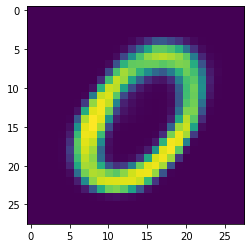

In [370]:
rand_0 = np.random.uniform(-2,2)
rand_1 = np.random.uniform(-2,2)
rand_2 = np.random.uniform(-0.5,0.5)
rand_3 = np.random.uniform(-0.2,0.4)
rand_4 = np.random.uniform(-1,1)
rand_5 = np.random.uniform(-0.1,0.1)
rand_6 = np.random.uniform(-0.1,0.2)
rand_7 = np.random.uniform(-2.3,2.5)
rand_8 = np.random.uniform(-0.2,0.2)
rand_9 = np.random.uniform(-0.2,0.2)
image = single_image_sampler(rand_0,rand_1,rand_2,rand_3,rand_4,rand_5,rand_6,rand_7,rand_8,rand_9)
img_max = image.max() 
plt.imshow(image)
plt.show()

In [142]:
from torchvision.utils import save_image
with torch.no_grad():
    count = 0
    z_fr1 = z_fr2 = torch.randn(100, 2)
    labels_y1 = torch.tensor(np.zeros((100,2)))
    labels_y2 = torch.tensor(np.zeros((100,2)))
    for i in range (0,10):
        for j in range (0,10):
            z_fr1[count,0] = z_fr2[count,0] = np.random.uniform(-1,1)
            z_fr1[count,1] = z_fr2[count,1] = np.random.uniform(-1,1)
            labels_y1[count,0] = 1
            labels_y2[count,1] = 1
            count = count +1 
        
    sample1 = vae.decoder([z_fr1,labels_y1.float()])
    
    save_image(sample1.view(100, 1, 100, 100), 'fr1_sample_z_space_' +str(epoch)+'.png',nrow=10)
    
    sample2 = vae.decoder([z_fr2,labels_y2.float()])

    save_image(sample2.view(100, 1, 100, 100), 'fr2_sample_z_space_' +str(epoch)+'.png',nrow=10) 

In [94]:
sample.reshape(100,100).cpu().detach().numpy()

array([[0.00018433, 0.00033273, 0.00033441, ..., 0.00035796, 0.00019329,
        0.00016873],
       [0.00021016, 0.00027572, 0.00041435, ..., 0.00036804, 0.00031961,
        0.0002838 ],
       [0.00024903, 0.00040582, 0.0006807 , ..., 0.00037013, 0.00034296,
        0.00029304],
       ...,
       [0.00030603, 0.00032814, 0.00037756, ..., 0.00041224, 0.00034986,
        0.00026457],
       [0.00028421, 0.00025892, 0.00030835, ..., 0.00039391, 0.00030643,
        0.00013053],
       [0.00014841, 0.00015673, 0.00026209, ..., 0.00039841, 0.00035061,
        0.0001815 ]], dtype=float32)

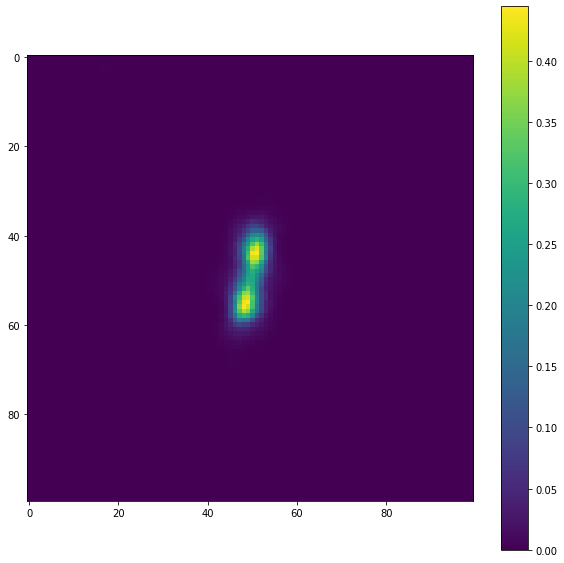

In [134]:
z = torch.randn(1, 2)
labels_y = torch.tensor(np.zeros((1,2)))
z[0,0]=0.5
z[0,1]=1.7
labels_y[0,1] = 0
labels_y[0,0] = 0
labels_y[0,1] = 1
sample = vae.decoder([z,labels_y.float()])

temp_array=sample.reshape(100,100).cpu().detach().numpy()
plt.figure(figsize = (10,10))
plt.imshow(temp_array)
plt.colorbar()
plt.show()



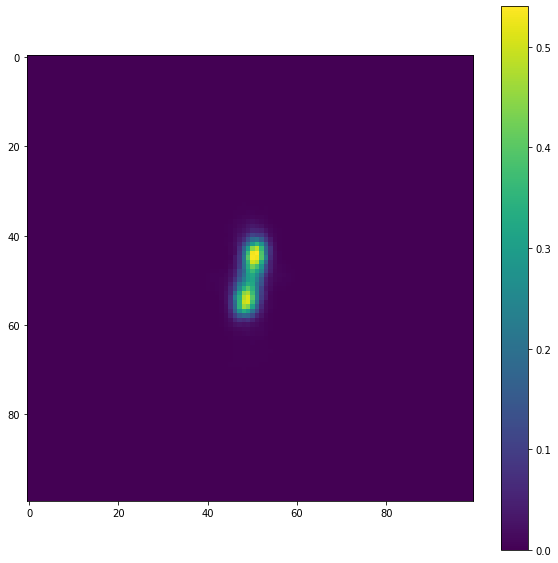

In [135]:
z = torch.randn(1, 2)
labels_y = torch.tensor(np.zeros((1,2)))
z[0,0]=0.5
z[0,1]=1.7
labels_y[0,1] = 0
labels_y[0,0] = 0
labels_y[0,0] = 1
sample = vae.decoder([z,labels_y.float()])

temp_array=sample.reshape(100,100).cpu().detach().numpy()
plt.figure(figsize = (10,10))
plt.imshow(temp_array)
plt.colorbar()
plt.show()